In [122]:
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

from core.multimodal.dataset2 import VPSMDatasetV2
from core.multimodal.model import ModelV1

In [2]:
def get_config(random_seed):
    config = {
        'project': 'multimodal-contrastive',
        'random_seed': random_seed,
        'use_wandb': True,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        'use_pretrain': None,

        # Data General
        'dataset': 'VPSMDatasetV2',     # 'VPSMDataset' or 'VPSMDatasetV2'
        'data_root': '/home/mariia/AstroML/data/asassn/',
        'file': 'preprocessed_data/full/spectra_and_v',
        'classes': None,
        'min_samples': 200,
        'max_samples': None,

        # Photometry
        'v_zip': 'asassnvarlc_vband_complete.zip',
        'v_prefix': 'vardb_files',
        'seq_len': 200,
        'phased': True,
        'clip': False,
        'aux': True,

        # Spectra
        'lamost_spec_dir': 'Spectra/v2',
        'spectra_v_file': 'spectra_v_merged.csv',
        'z_corr': False,

        # Photometry Model
        'p_encoder_layers': 8,
        'p_d_model': 128,
        'p_dropout': 0,
        'p_feature_size': 3,
        'p_n_heads': 4,
        'p_d_ff': 512,

        # Spectra Model
        's_hidden_dim': 512,
        's_dropout': 0,

        # Metadata Model
        'm_hidden_dim': 512,
        'm_dropout': 0,

        # MultiModal Model
        'model': 'ModelV1',     # 'ModelV0' or 'ModelV1'
        'hidden_dim': 256,

        # Training
        'batch_size': 32,
        'lr': 1e-3,
        'weight_decay': 0,
        'epochs': 50,
        'optimizer': 'AdamW',
        'early_stopping_patience': 100,

        # Learning Rate Scheduler
        'factor': 0.3,
        'patience': 50,
    }

    config['p_feature_size'] += 4

    return config

In [3]:
config = get_config(42)
CLASSES = ['EW', 'SR', 'EA', 'RRAB', 'EB', 'ROT', 'RRC', 'HADS', 'M', 'DSCT']

In [4]:
train_dataset = VPSMDatasetV2(split='train', classes=CLASSES, seq_len=200, phased=True, clip=False, aux=True, z_corr=False, random_seed=42)
val_dataset = VPSMDatasetV2(split='val', classes=CLASSES, seq_len=200, phased=True, clip=False, aux=True, z_corr=False, random_seed=42)
test_dataset = VPSMDatasetV2(split='test', classes=CLASSES, seq_len=200, phased=True, clip=False, aux=True, z_corr=False, random_seed=42)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelV1(config)
model.load_state_dict(torch.load('/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth'))
model = model.to(device)
model.eval()

ModelV1(
  (photometry_encoder): Informer(
    (enc_embedding): DataEmbedding(
      (value_embedding): TokenEmbedding(
        (tokenConv): Conv1d(7, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
      )
      (position_embedding): PositionalEmbedding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (attn_layers): ModuleList(
        (0-7): 8 x EncoderLayer(
          (attention): AttentionLayer(
            (inner_attention): ProbAttention(
              (dropout): Dropout(p=0, inplace=False)
            )
            (query_projection): Linear(in_features=128, out_features=128, bias=True)
            (key_projection): Linear(in_features=128, out_features=128, bias=True)
            (value_projection): Linear(in_features=128, out_features=128, bias=True)
            (out_projection): Linear(in_features=128, out_features=128, bias=True)
          )
          (conv1): Conv1d(128, 512, kernel_size=(1,), stride=(1

In [138]:
photometry, photometry_mask, spectra, metadata, y = next(iter(val_dataloader))
photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
spectra, metadata = spectra.to(device), metadata.to(device)

In [139]:
logits_ps, logits_sm, logits_mp = model(photometry, photometry_mask, spectra, metadata)

In [145]:
labels = torch.arange(logits_ps.shape[0], dtype=torch.int64, device=device)

_, pred_labels_ps = torch.max(F.softmax(logits_ps, dim=1), dim=1)
_, pred_labels_sp = torch.max(F.softmax(logits_ps.transpose(-1, -2), dim=1), dim=1)

_, pred_labels_sm = torch.max(F.softmax(logits_sm, dim=1), dim=1)
_, pred_labels_ms = torch.max(F.softmax(logits_sm.transpose(-1, -2), dim=1), dim=1)

_, pred_labels_mp = torch.max(F.softmax(logits_mp, dim=1), dim=1)
_, pred_labels_pm = torch.max(F.softmax(logits_mp.transpose(-1, -2), dim=1), dim=1)

print(f'Correct predictions ps: {(pred_labels_ps == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions sp: {(pred_labels_sp == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions sm: {(pred_labels_sm == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions ms: {(pred_labels_ms == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions mp: {(pred_labels_mp == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions pm: {(pred_labels_pm == labels).sum().item()}/{len(pred_labels)}')

Correct predictions ps: 6/32
Correct predictions sp: 5/32
Correct predictions sm: 16/32
Correct predictions ms: 13/32
Correct predictions mp: 27/32
Correct predictions pm: 28/32


In [31]:
model.logit_scale_ps, model.logit_scale_sm, model.logit_scale_mp

(Parameter containing:
 tensor(3.9262, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(4.0507, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(4.6054, device='cuda:0', requires_grad=True))

In [147]:
prob_ps = (F.softmax(logits_ps, dim=1) + F.softmax(logits_ps.transpose(-1, -2), dim=1)) / 2
prob_sm = (F.softmax(logits_sm, dim=1) + F.softmax(logits_sm.transpose(-1, -2), dim=1)) / 2
prob_mp = (F.softmax(logits_mp, dim=1) + F.softmax(logits_mp.transpose(-1, -2), dim=1)) / 2

prob = (prob_ps + prob_sm + prob_mp) / 3
_, pred_labels = torch.max(prob, dim=1)

print(f'Correct predictions avg: {(pred_labels == labels).sum().item()}/{len(pred_labels)}')

Correct predictions avg: 28/32


In [148]:
prob_ps = prob_ps.cpu().detach().numpy()
prob_sm = prob_sm.cpu().detach().numpy()
prob_mp = prob_mp.cpu().detach().numpy()
prob = prob.cpu().detach().numpy()

In [149]:
y

tensor([3, 9, 7, 9, 7, 8, 7, 3, 1, 9, 7, 1, 9, 9, 7, 2, 3, 7, 7, 6, 6, 6, 7, 7,
        1, 6, 8, 4, 9, 9, 3, 9])

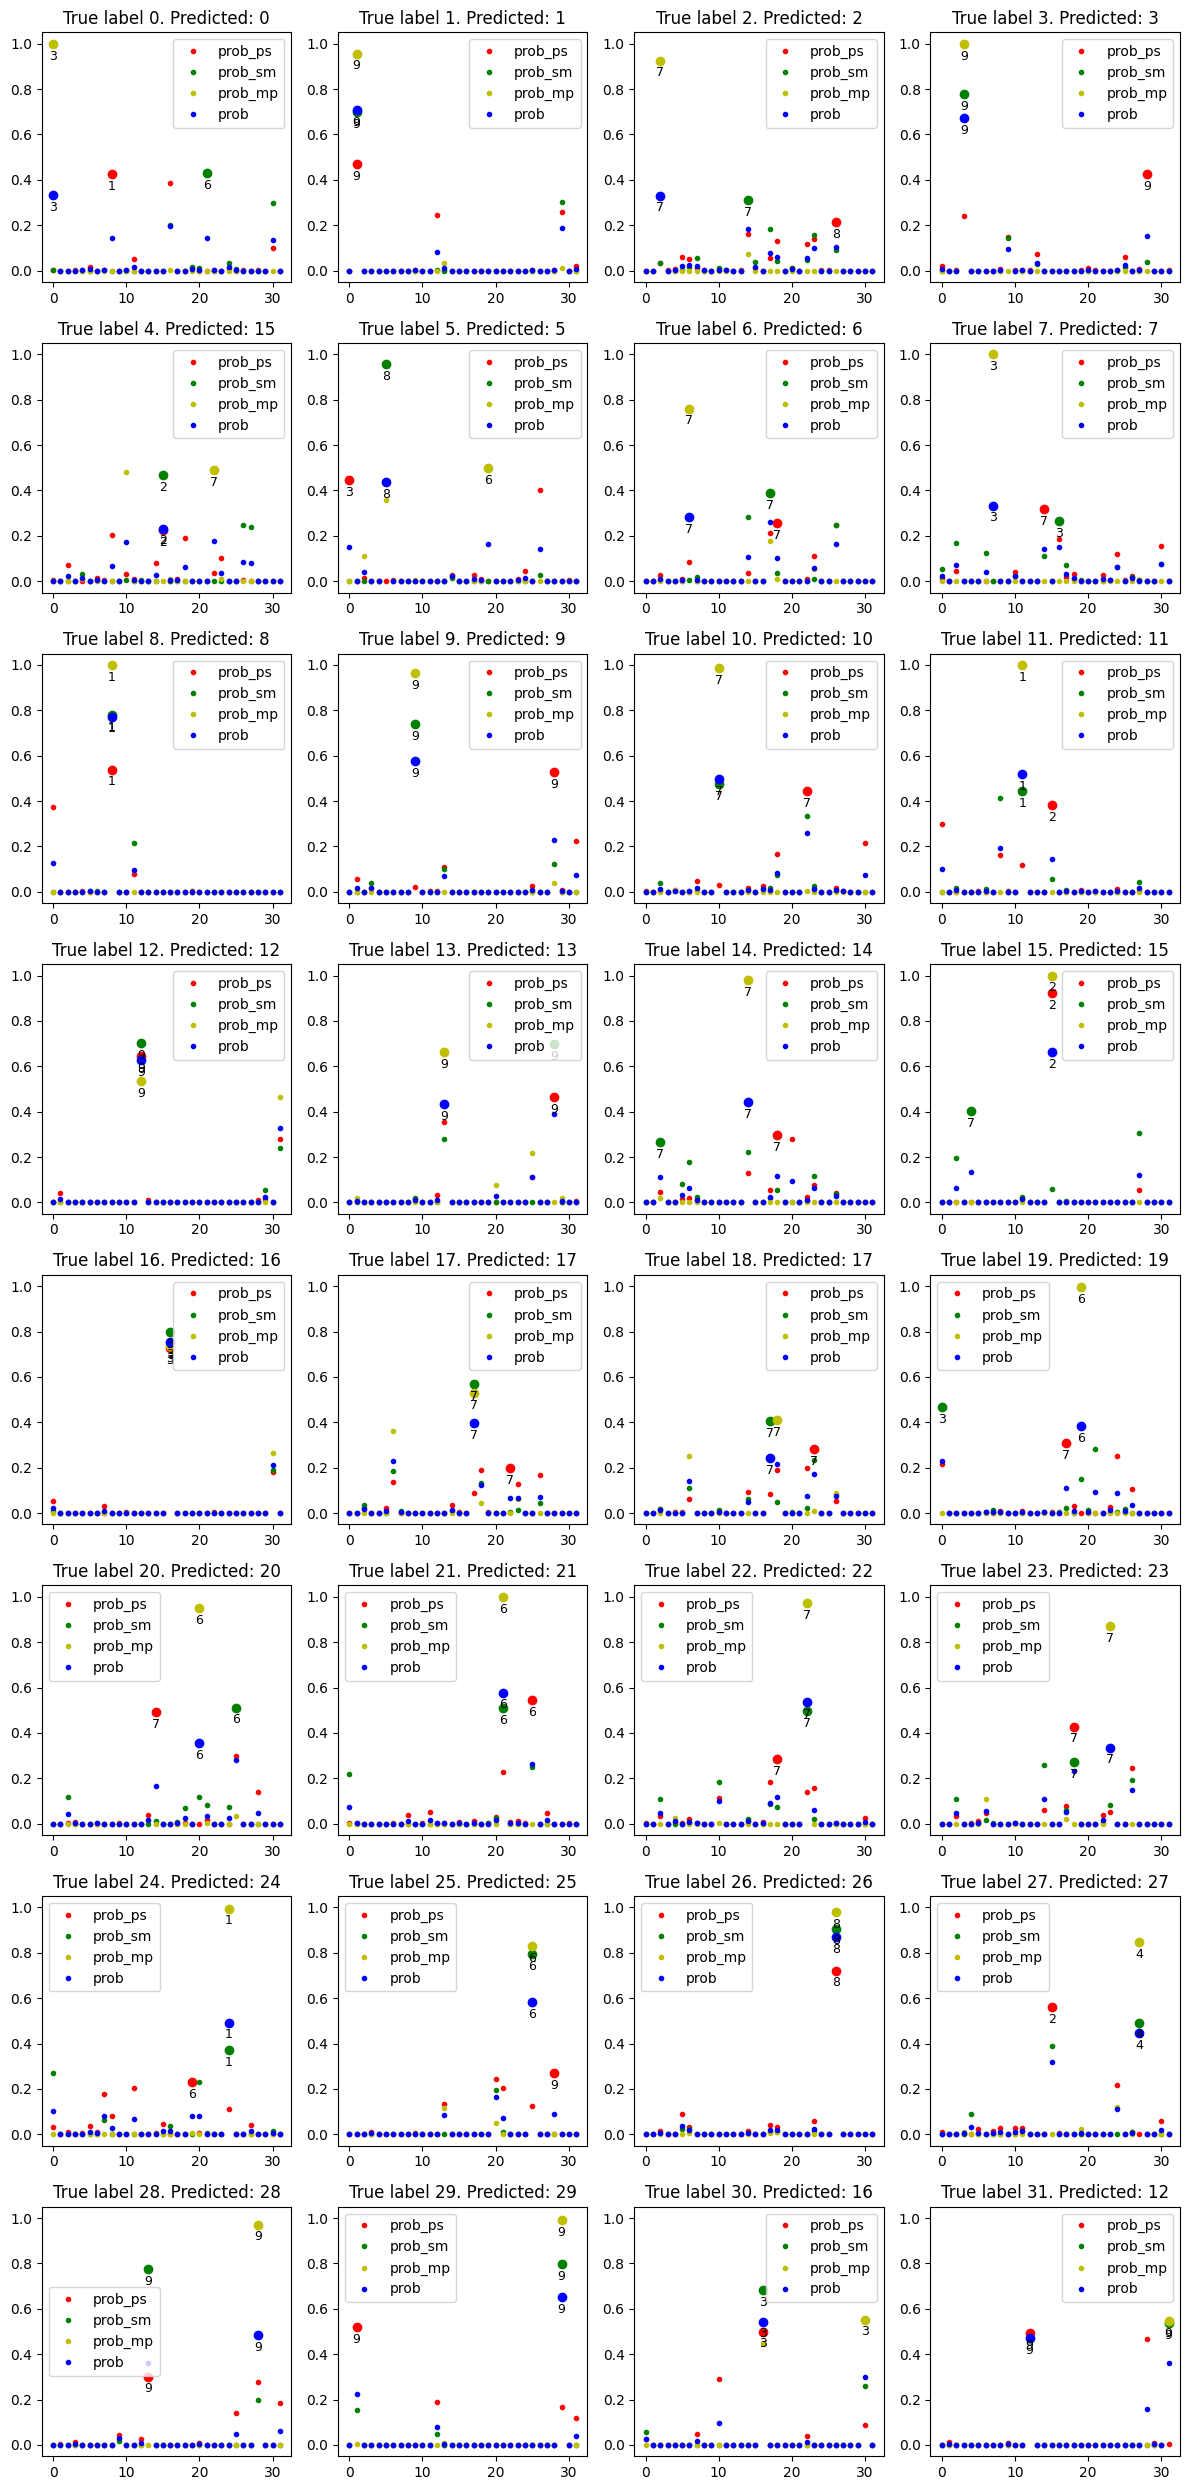

In [159]:
fig, axs = plt.subplots(8, 4, figsize=(12, 25))

for i in range(32):
    ax = axs[i // 4, i % 4]  # Determine the position of the subplot
    ax.set_ylim(-0.05, 1.05)

    for data, color, label, y_true in zip((prob_ps, prob_sm, prob_mp, prob), ('r', 'g', 'y', 'b'), ('prob_ps', 'prob_sm', 'prob_mp', 'prob'), y):
        ax.plot(data[i], f'{color}.', label=label)

        max_idx = np.argmax(data[i])
        max_val = data[i][max_idx]
        ax.plot(max_idx, max_val, f'{color}o')
        ax.text(max_idx, max_val - 0.07, f'{y[max_idx]}', fontsize=9, ha='center')

        if label == 'prob':
            ax.set_title(f'True label {i}. Predicted: {max_idx}')
            ax.legend()
    
plt.tight_layout()
plt.show()

Correct predictions ps: 17/32
Correct predictions sp: 19/32
Correct predictions sm: 24/32
Correct predictions ms: 23/32
Correct predictions mp: 31/32
Correct predictions pm: 29/32
Correct predictions avg: 32/32


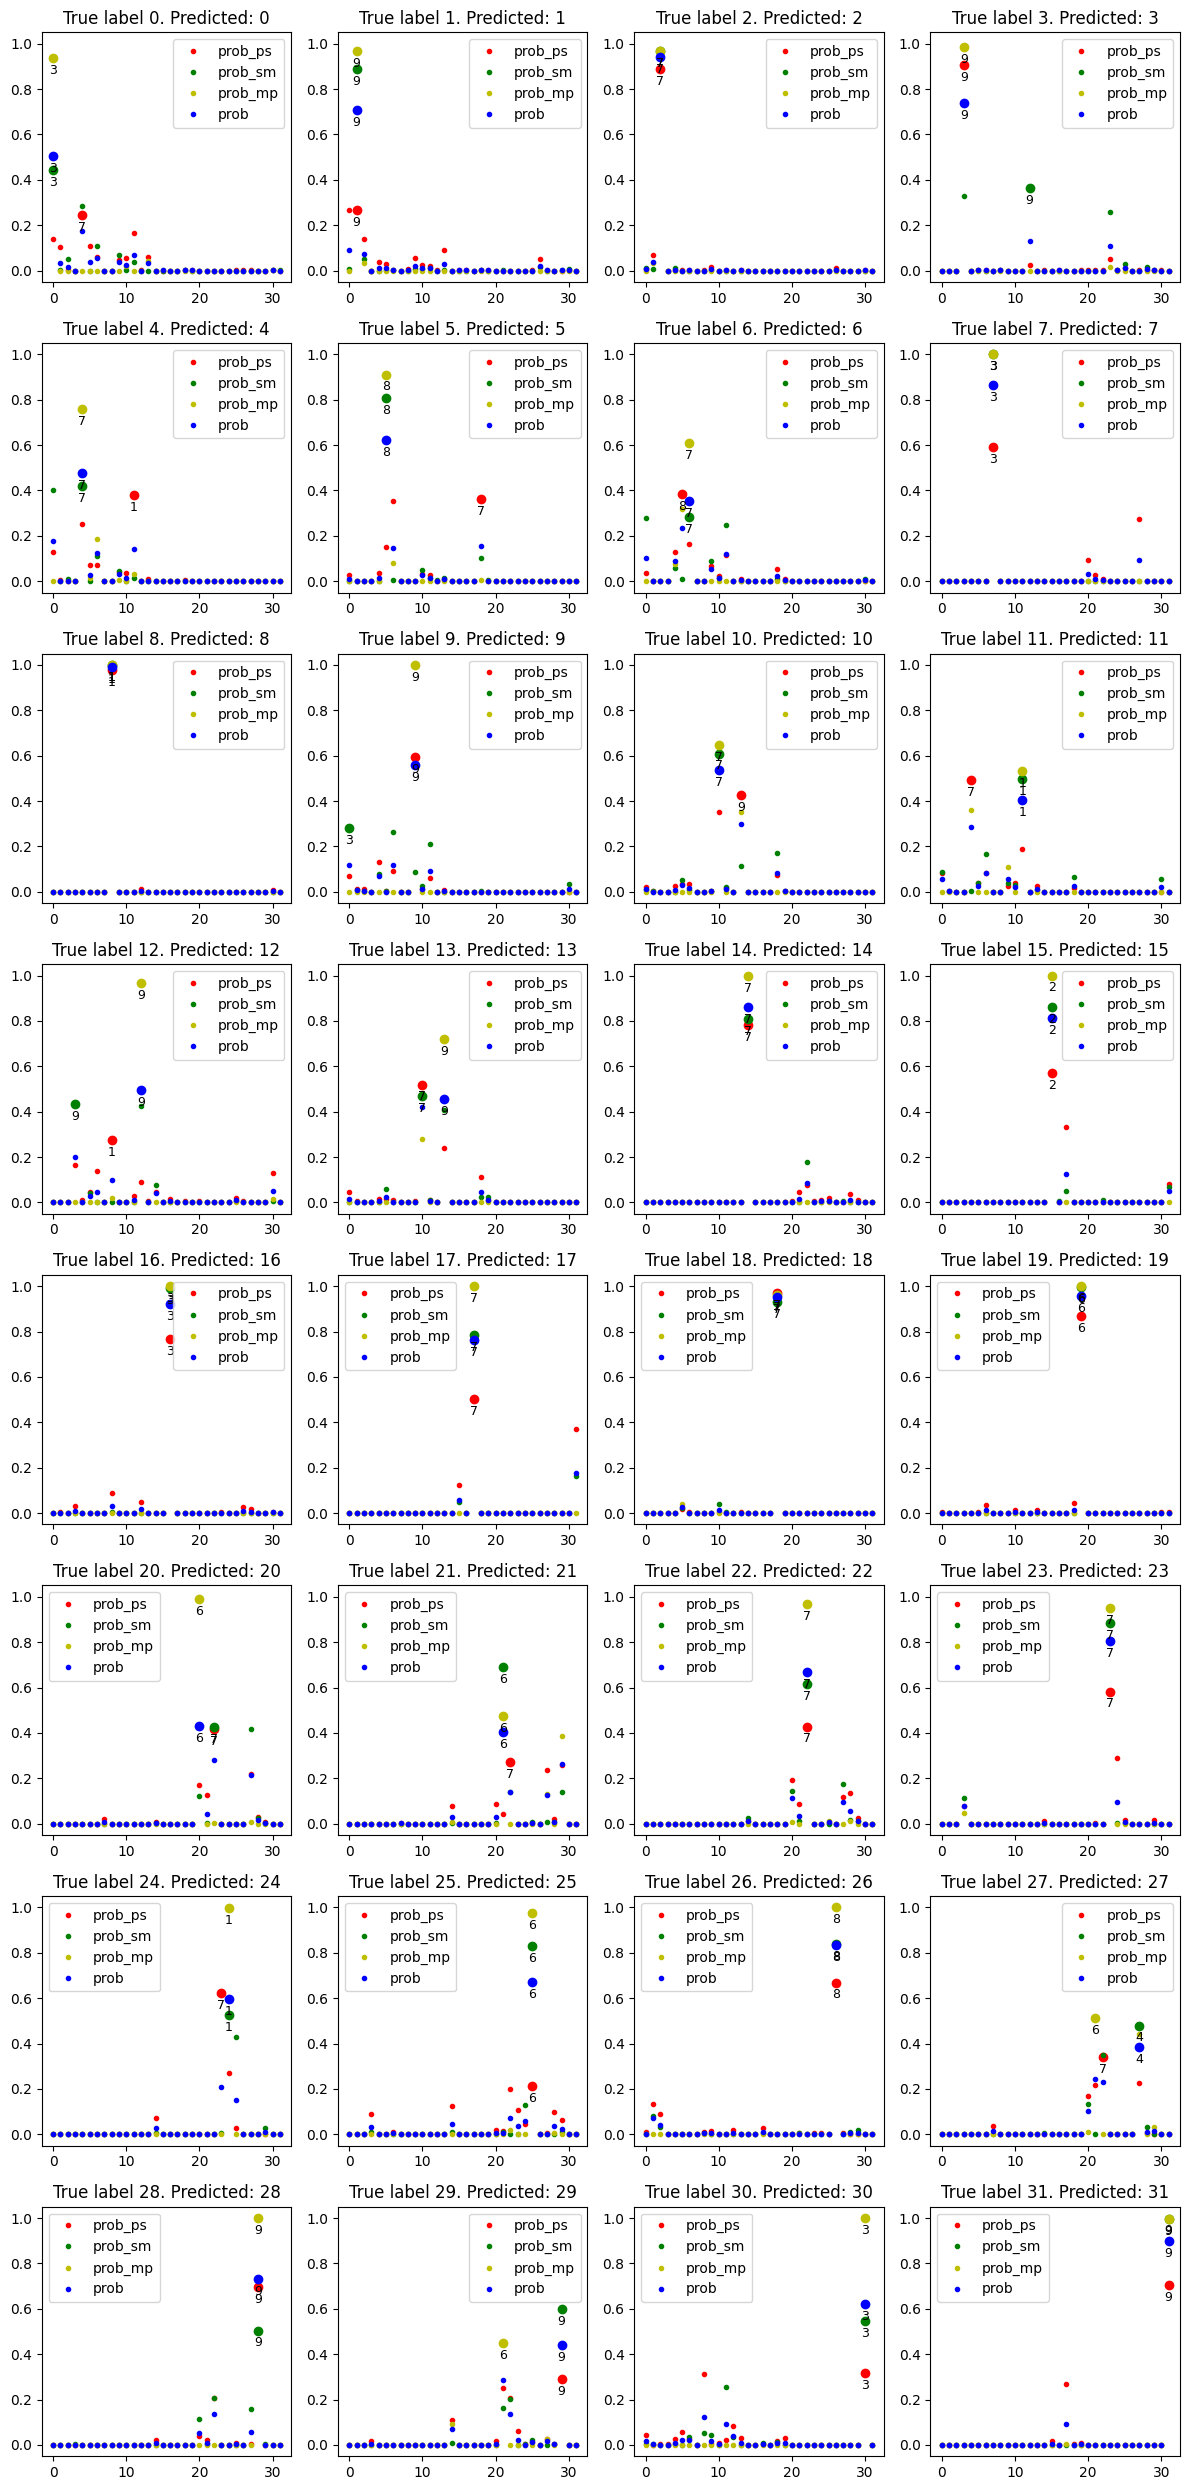

In [160]:
photometry, photometry_mask, spectra, metadata, label = next(iter(train_dataloader))
photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
spectra, metadata = spectra.to(device), metadata.to(device)

logits_ps, logits_sm, logits_mp = model(photometry, photometry_mask, spectra, metadata)
labels = torch.arange(logits_ps.shape[0], dtype=torch.int64, device=device)

_, pred_labels_ps = torch.max(F.softmax(logits_ps, dim=1), dim=1)
_, pred_labels_sp = torch.max(F.softmax(logits_ps.transpose(-1, -2), dim=1), dim=1)

_, pred_labels_sm = torch.max(F.softmax(logits_sm, dim=1), dim=1)
_, pred_labels_ms = torch.max(F.softmax(logits_sm.transpose(-1, -2), dim=1), dim=1)

_, pred_labels_mp = torch.max(F.softmax(logits_mp, dim=1), dim=1)
_, pred_labels_pm = torch.max(F.softmax(logits_mp.transpose(-1, -2), dim=1), dim=1)

print(f'Correct predictions ps: {(pred_labels_ps == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions sp: {(pred_labels_sp == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions sm: {(pred_labels_sm == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions ms: {(pred_labels_ms == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions mp: {(pred_labels_mp == labels).sum().item()}/{len(pred_labels)}')
print(f'Correct predictions pm: {(pred_labels_pm == labels).sum().item()}/{len(pred_labels)}')

prob_ps = (F.softmax(logits_ps, dim=1) + F.softmax(logits_ps.transpose(-1, -2), dim=1)) / 2
prob_sm = (F.softmax(logits_sm, dim=1) + F.softmax(logits_sm.transpose(-1, -2), dim=1)) / 2
prob_mp = (F.softmax(logits_mp, dim=1) + F.softmax(logits_mp.transpose(-1, -2), dim=1)) / 2

prob = (prob_ps + prob_sm + prob_mp) / 3
_, pred_labels = torch.max(prob, dim=1)

print(f'Correct predictions avg: {(pred_labels == labels).sum().item()}/{len(pred_labels)}')

prob_ps = prob_ps.cpu().detach().numpy()
prob_sm = prob_sm.cpu().detach().numpy()
prob_mp = prob_mp.cpu().detach().numpy()
prob = prob.cpu().detach().numpy()

fig, axs = plt.subplots(8, 4, figsize=(12, 25))

for i in range(32):
    ax = axs[i // 4, i % 4]  # Determine the position of the subplot
    ax.set_ylim(-0.05, 1.05)

    for data, color, label, y_true in zip((prob_ps, prob_sm, prob_mp, prob), ('r', 'g', 'y', 'b'), ('prob_ps', 'prob_sm', 'prob_mp', 'prob'), y):
        ax.plot(data[i], f'{color}.', label=label)

        max_idx = np.argmax(data[i])
        max_val = data[i][max_idx]
        ax.plot(max_idx, max_val, f'{color}o')
        ax.text(max_idx, max_val - 0.07, f'{y[max_idx]}', fontsize=9, ha='center')

        if label == 'prob':
            ax.set_title(f'True label {i}. Predicted: {max_idx}')
            ax.legend()
                
plt.tight_layout()
plt.show()

In [163]:
p_embeddings, s_embeddings, m_embeddings, labels = [], [], [], []

for photometry, photometry_mask, spectra, metadata, label in tqdm(train_dataloader):
    photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
    spectra, metadata = spectra.to(device), metadata.to(device)
    
    p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    p_embeddings.append(p_emb.cpu().detach().numpy())
    s_embeddings.append(s_emb.cpu().detach().numpy())
    m_embeddings.append(m_emb.cpu().detach().numpy())
    labels.append(label.numpy())

100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [03:40<00:00,  2.45it/s]


In [164]:
p_embeddings = np.vstack(p_embeddings)
s_embeddings = np.vstack(s_embeddings)
m_embeddings = np.vstack(m_embeddings)
labels = np.concatenate(labels)

In [165]:
umap_p_emb = umap.UMAP(metric='cosine').fit_transform(p_embeddings)

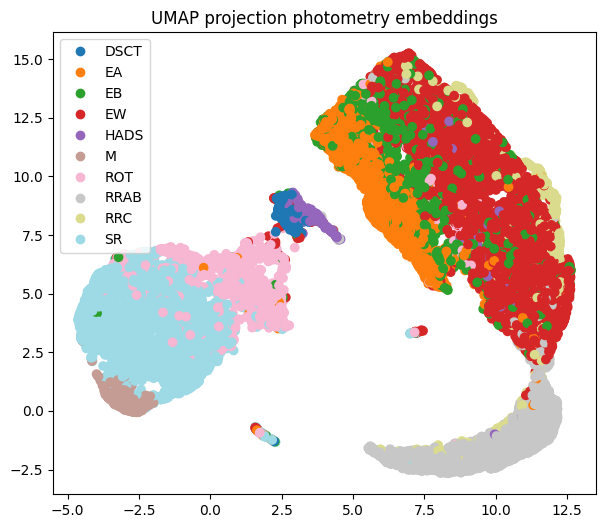

In [166]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(umap_p_emb[:, 0], umap_p_emb[:, 1], cmap='tab20', c=labels)
# scatter = plt.scatter(umap_p_emb[:, 0], umap_p_emb[:, 1], c=numeric_labels, cmap='tab20', s=5)
# plt.clim(-0.5, len(le.classes_)-0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.id2target.values())
plt.title('UMAP projection photometry embeddings')
plt.show()

In [167]:
umap_s_emb = umap.UMAP(metric='cosine').fit_transform(s_embeddings)

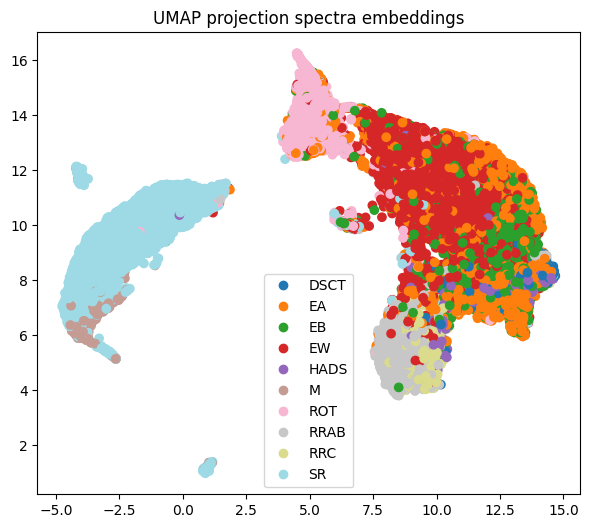

In [168]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(umap_s_emb[:, 0], umap_s_emb[:, 1], cmap='tab20', c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.id2target.values())
plt.title('UMAP projection spectra embeddings')
plt.show()

In [169]:
umap_m_emb = umap.UMAP(metric='cosine').fit_transform(m_embeddings)

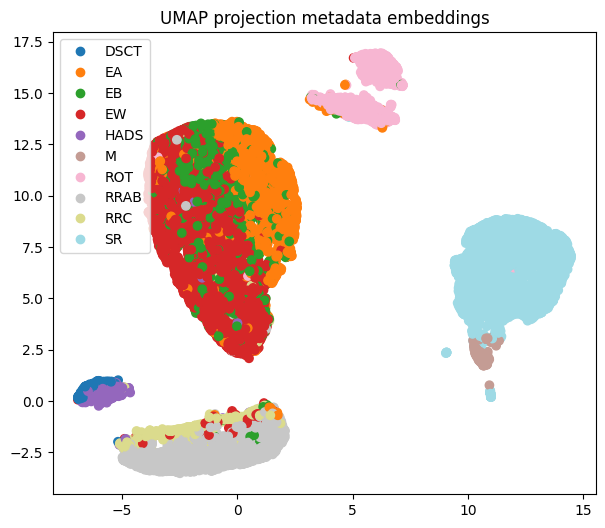

In [170]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(umap_m_emb[:, 0], umap_m_emb[:, 1], cmap='tab20', c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.id2target.values())
plt.title('UMAP projection metadata embeddings')
plt.show()

In [171]:
embeddings = np.concatenate([p_embeddings, s_embeddings, m_embeddings], axis=0)

In [172]:
umap_emb = umap.UMAP(metric='cosine').fit_transform(embeddings)

In [173]:
all_labels = np.concatenate([labels, labels, labels], axis=0)

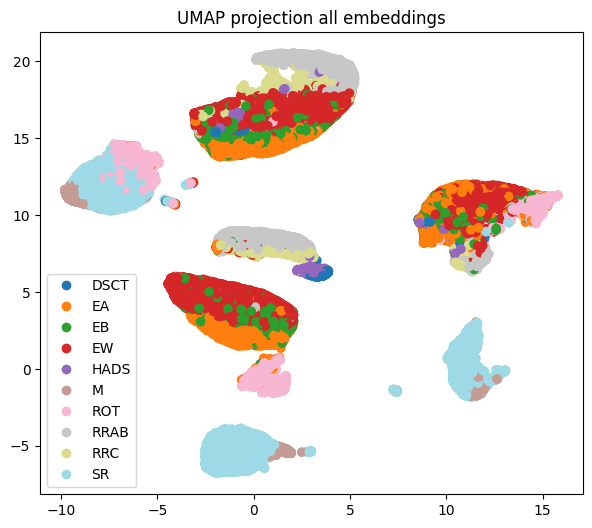

In [174]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(umap_emb[:, 0], umap_emb[:, 1], cmap='tab20', c=all_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.id2target.values())
plt.title('UMAP projection all embeddings')
plt.show()

In [175]:
tsne_p_emb = TSNE(metric='cosine').fit_transform(p_embeddings)

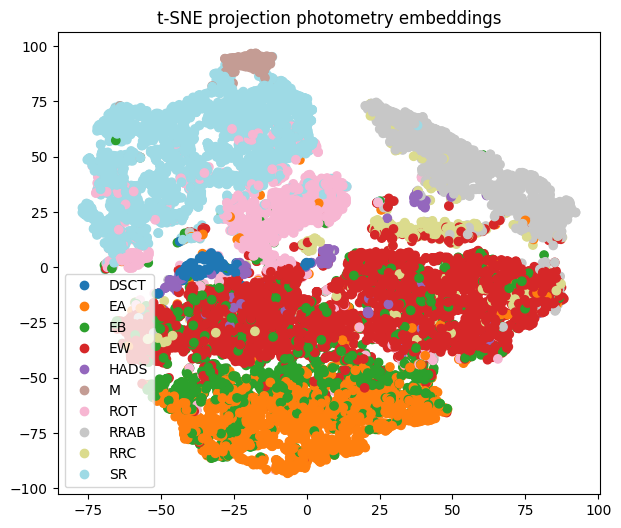

In [176]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(tsne_p_emb[:, 0], tsne_p_emb[:, 1], cmap='tab20', c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.id2target.values())
plt.title('t-SNE projection photometry embeddings')
plt.show()

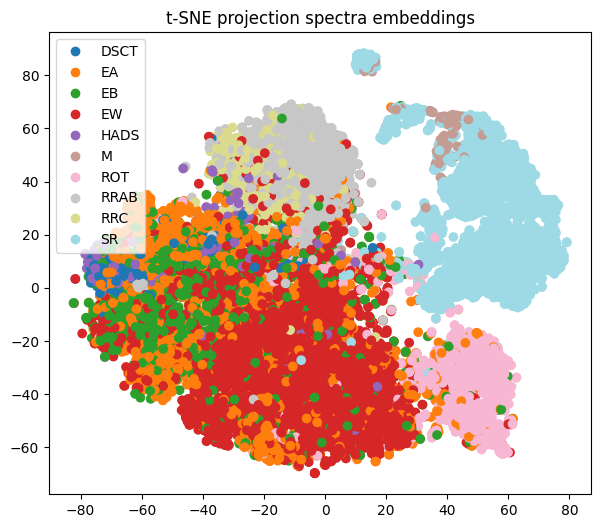

In [177]:
tsne_s_emb = TSNE(metric='cosine').fit_transform(s_embeddings)
plt.figure(figsize=(7, 6))
scatter = plt.scatter(tsne_s_emb[:, 0], tsne_s_emb[:, 1], cmap='tab20', c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.id2target.values())
plt.title('t-SNE projection spectra embeddings')
plt.show()

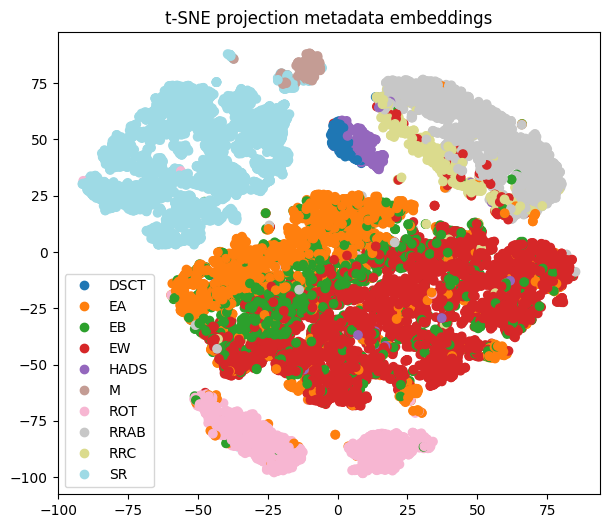

In [178]:
tsne_m_emb = TSNE(metric='cosine').fit_transform(m_embeddings)
plt.figure(figsize=(7, 6))
scatter = plt.scatter(tsne_m_emb[:, 0], tsne_m_emb[:, 1], cmap='tab20', c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.id2target.values())
plt.title('t-SNE projection metadata embeddings')
plt.show()

In [179]:
all_colors2 = np.concatenate([labels, 
                              [el + train_dataset.num_classes for el in labels], 
                              [el + 2 * train_dataset.num_classes for el in labels]])
all_labels2 = [f'{el}-p' for el in train_dataset.id2target.values()] + [f'{el}-s' for el in train_dataset.id2target.values()] + [f'{el}-m' for el in train_dataset.id2target.values()]

In [180]:
tsne_emb = TSNE(metric='cosine').fit_transform(embeddings)

In [181]:
tsne_emb.shape, all_colors2.shape, np.unique(all_colors2)

((51825, 2),
 (51825,),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

In [182]:
# Define base colors for each category
base_colors = {
    'DSCT': 'blue',
    'EA': 'green',
    'EB': 'red',
    'EW': 'purple',
    'HADS': 'orange',
    'M': 'brown',
    'ROT': 'pink',
    'RRAB': 'gray',
    'RRC': 'olive',
    'SR': 'cyan'
}

# Define brightness variations for '-p', '-s', '-m'
brightness = {
    'p': 0.7,
    's': 0.85,
    'm': 1.0
}

def adjust_brightness(color, brightness):
    # Adjust color brightness
    c = mcolors.ColorConverter().to_rgb(color)
    c = [min(1, i * brightness) for i in c]
    return c

# Create a color map for the labels
color_map = {}
for label in all_labels2:
    base_label = label.split('-')[0]
    variant = label.split('-')[1]
    color_map[label] = adjust_brightness(base_colors[base_label], brightness[variant])

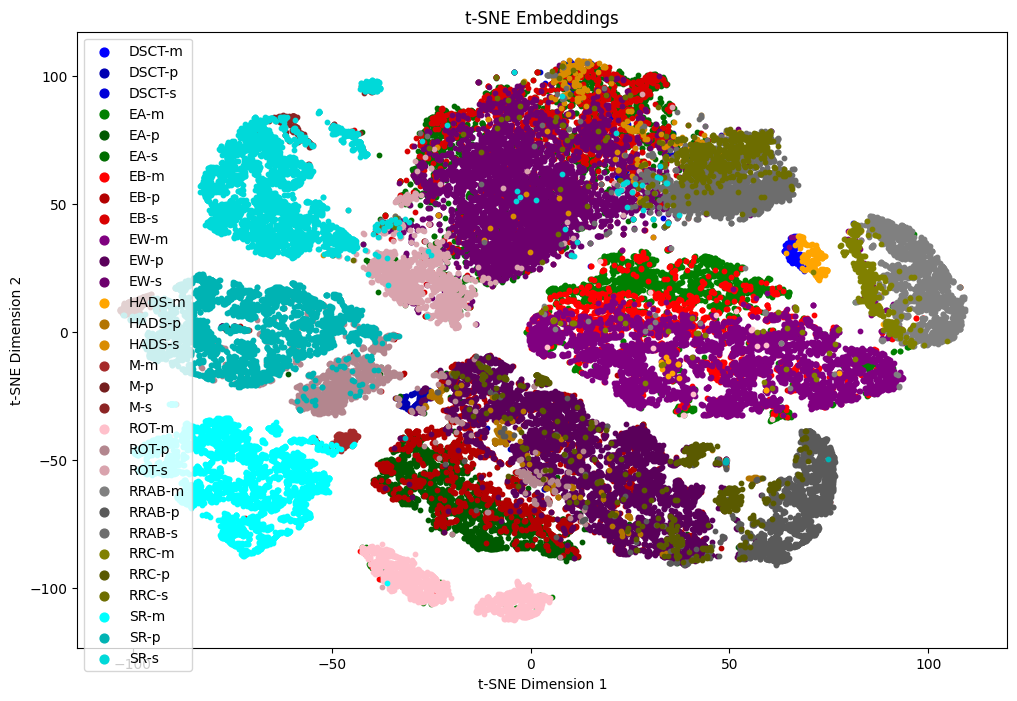

In [183]:
plt.figure(figsize=(12, 8))

for label in np.unique(all_colors2):
    indices = np.where(all_colors2 == label)
    plt.scatter(tsne_emb[indices, 0], tsne_emb[indices, 1], label=f'{all_labels2[label]}', s=10, c=[color_map[all_labels2[label]]])

plt.title('t-SNE Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Gather handles and labels, then sort them
handles, labels = plt.gca().get_legend_handles_labels()
sorted_labels_handles = sorted(zip(labels, handles))
sorted_labels, sorted_handles = zip(*sorted_labels_handles)

# Add sorted legend
plt.legend(sorted_handles, sorted_labels, loc='best', markerscale=2)
plt.show()